### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [3]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [4]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Krish"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Krish

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Krish

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke(messages)

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 1545,
  'prompt_tokens': 54,
  'total_tokens': 1599,
  'completion_time': 4.7048161539999995,
  'prompt_time': 0.001999059,
  'queue_time': 0.05407359,
  'total_time': 4.7068152130000005},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [7]:
def add(a:int,b:int)-> int:
    """
    Add a and b
    Args:
         a(int): first int
         b(int): second int
    
    Returns:
           int 

    """
    return a + b
    

In [8]:
## Binding tool with llm 

llm_with_tools = llm.bind_tools([add])

tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3",name="Himanshu")])

In [9]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'fntvdkgkn',
  'type': 'tool_call'}]

In [10]:
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated

class State(TypedDict):
    message:list[AnyMessage]

In [11]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

Reducers with add_message

In [12]:
initial_messages=[AIMessage(content=f"Please tell me how can i help",name="llMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Himanshu"))
initial_messages


[AIMessage(content='Please tell me how can i help', additional_kwargs={}, response_metadata={}, name='llMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Himanshu')]

In [13]:
ai_message=(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [14]:
### Reducers add_message is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can i help', additional_kwargs={}, response_metadata={}, name='llMModel', id='d2c6d911-a2cb-4739-81f2-4464f9818ddb'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Himanshu', id='c951150b-c0f9-4329-b53c-6b97b6adeea5'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='917b1a30-0012-482d-a67b-0ce8f177976a')]

In [15]:
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

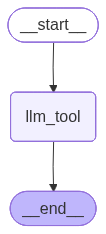

In [16]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
## Invocation 

messages=graph.invoke({"messages":"what is 2 plus 3"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2 plus 3
================================== Ai Message ==================================
Tool Calls:
  add (3xv2mmw3d)
 Call ID: 3xv2mmw3d
  Args:
    a: 2
    b: 3


In [18]:
tools=[add]

In [24]:
%pip install ToolNode

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ToolNode (from versions: none)
ERROR: No matching distribution found for ToolNode


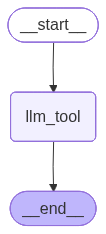

In [21]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

     tools_condition
)
builder.add_edge("tools",END)

graph_builder=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
## Invocation 

messages=graph.invoke({"messages":"what is Agentic AI"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is Agentic AI
================================== Ai Message ==================================

Agentic AI refers to artificial intelligence systems designed to operate as autonomous agents, capable of performing tasks, making decisions, and interacting with environments or users with varying degrees of independence. These systems exhibit traits such as **autonomy** (acting without direct human control), **reactivity** (responding to dynamic environments), **proactivity** (anticipating needs/goals), and **social ability** (collaborating with other agents or humans). 

Key applications include:
- **Self-driving cars** (perceiving surroundings, navigating roads).
- **Customer service chatbots** (handling queries, resolving issues).
- **Personal assistants** (managing schedules, executing commands like Siri/Google Assistant).
- **Game-playing AI** (adapting strategies in real-time, e.g., AlphaGo).

Unde